# YouTube Trending Videos Analysis

## Group 4 - Members
* Shyam Akhil Nekkanti - 8982123
* Jun He (Helena) - 8903073
* Zheming Li (Brendan) - 8914152

## Summary Update

We are analyzing factors influencing YouTube video trending patterns in the US for 2018. 

We've expanded our analysis to include time series exploration of daily total views for trending videos. 

Our revised hypothesis testing focuses on whether the day of the week a video is added to the trending tab affects its views, 
building on our previous analysis of category differences in trending duration. 

By examining seasonal patterns, the correlation between first-trending-day views and the overall trending duration, and day-of-week effects, 

the aim is to uncover insights into video popularity dynamics

the final goal remains the same - to predict the number of days a video will trend for, between 1 - 30 days

## New Hypothesis based on time series data

### Null Hypothesis (H0):
There is no significant difference in the mean number of views for videos that starts trending on different days of the week.

### Alternative Hypothesis (H1):
There is a significant difference in the mean number of views for videos that start trending on different days of the week.

This hypothesis allows us to analyze whether the day of publication influences a video's popularity, 

this could be a crucial factor in determining the total trending duration of the video, based on it's initial reception.

## Data Loading and Preprocessing

In [9]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Load and preprocess data
def load_category_mapping(json_file):
    with open(json_file, 'r') as f:
        category_data = json.load(f)
    formatted_categories = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
    return formatted_categories

def load_and_preprocess_data(csv_file, category_mapping):
    df = pd.read_csv(csv_file)
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
    df['publish_time'] = pd.to_datetime(df['publish_time'])
    df['category_name'] = df['category_id'].map(category_mapping)
    numerical_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numerical_cols:
        df[f'log_{col}'] = np.log1p(df[col])
    df['likes_ratio'] = df['likes'] / (df['views'] + 1)
    df['dislikes_ratio'] = df['dislikes'] / (df['views'] + 1)
    df['comment_ratio'] = df['comment_count'] / (df['views'] + 1)
    return df

def calc_trending_duration(df):
    trending_counts = df.groupby('video_id').size().reset_index(name='trending_duration')
    df = df.merge(trending_counts, on='video_id', how='left')
    return df

# Load the data
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)
df = calc_trending_duration(df)

print(f"Loaded {len(df)} records")
df.head()

Loaded 40949 records


video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  puqaWrEC7tY    2017-11-14   
4  d380meD0W0M    2017-11-14   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22 2017-11-13 17:13:01+00:00   
1           24 2017-11-13 07:30:00+00:00   
2           23 2017-11-12 19:05:24+00:00   
3           24 2017-11-13 11:00:04+00:00   
4           24 2017-11-12 18:01:41+00:00   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   
3  rhett and link|"gmm"|"good mythical morning"|"...   343168   10172   
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  2095731  132235   

   dislikes  ...                                        description  \
0      2966  ...  SHANTELL'S CHANNEL - https://www.youtube.com/s...   
1      6146  ...  One year after the presidential election, John...   
2      5339  ...  WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...   
3       666  ...  Today we find out if Link is a Nickelback amat...   
4      1989  ...  I know it's been a while since we did this sho...   

    category_name  log_views  log_likes  log_dislikes log_comment_count  \
0  People & Blogs  13.525659  10.960027      7.995307          9.677528   
1   Entertainment  14.698775  11.484382      8.723719          9.449672   
2          Comedy  14.975981  11.891595      8.582981          9.009692   
3   Entertainment  12.745978   9.227492      6.502790          7.671827   
4   Entertainment  14.555413  11.792343      7.595890          9.771041   

  likes_ratio  dislikes_ratio  comment_ratio  trending_duration  
0    0.076869        0.003963       0.021318                  7  
1    0.040179        0.002541       0.005252                  7  
2    0.045758        0.001673       0.002563                  7  
3    0.029641        0.001941       0.006253                  7  
4    0.063097        0.000949       0.008359                  6  

[5 rows x 25 columns]

## Time Series Analysis

We'll now generate a time series of daily total views for trending videos in 2018 and analyze its patterns and trends.

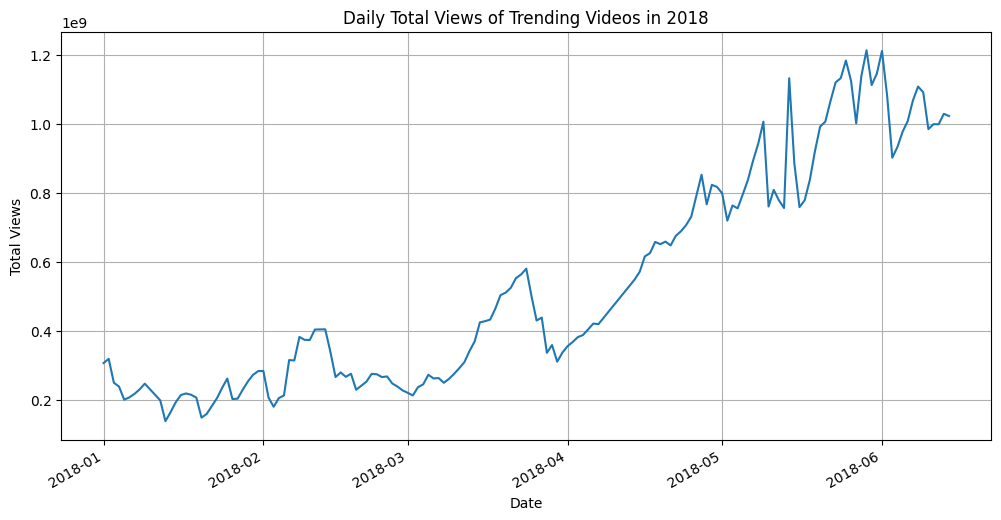

In [10]:
# Generate time series of daily total views
daily_views = df[df['trending_date'].dt.year == 2018].groupby('trending_date')['views'].sum().reset_index()
daily_views = daily_views.set_index('trending_date')

# Plot the time series
plt.figure(figsize=(12, 6))
daily_views['views'].plot()
plt.title('Daily Total Views of Trending Videos in 2018')
plt.xlabel('Date')
plt.ylabel('Total Views')
plt.grid(True)
plt.show()

### Pattern and Trend Identification

From the time series plot, we can observe several key patterns:

1. Overall Upward Trend: There's a general increase in daily total views throughout 2018, suggesting growing engagement with trending videos over time.

2. Weekly Seasonality: Regular fluctuations occur with a period of about 7 days, indicating weekly patterns in viewing behavior.

3. Volatility: The series shows high day-to-day variability, with occasional sharp spikes that could correspond to viral videos or major events.

4. Non-linear Growth: The upward trend isn't uniform, with periods of faster and slower growth throughout the year.

These patterns suggest that the popularity of trending videos is influenced by both long-term factors (overall growth in platform usage) and short-term factors (day of the week, specific viral content).

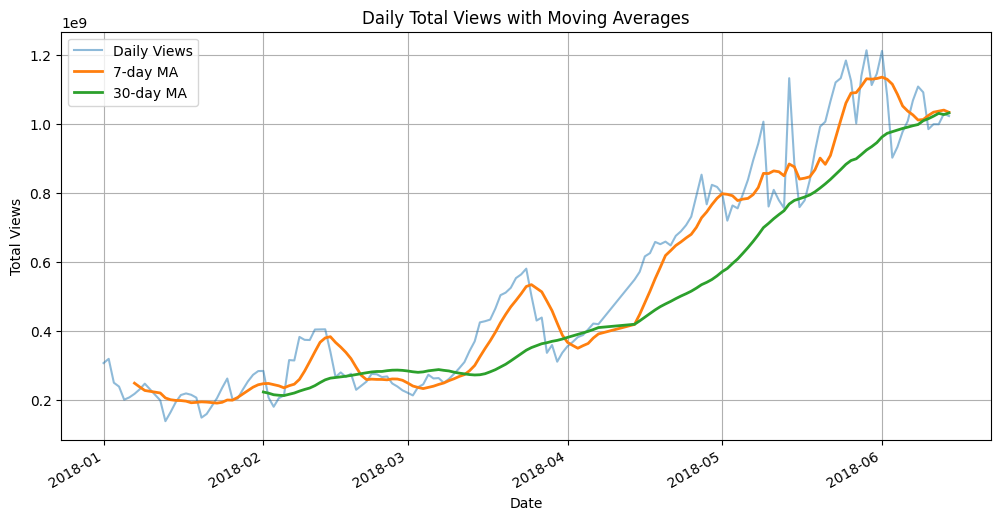

In [11]:
# Calculate and plot moving averages
daily_views['MA7'] = daily_views['views'].rolling(window=7).mean()
daily_views['MA30'] = daily_views['views'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
daily_views['views'].plot(label='Daily Views', alpha=0.5)
daily_views['MA7'].plot(label='7-day MA', linewidth=2)
daily_views['MA30'].plot(label='30-day MA', linewidth=2)
plt.title('Daily Total Views with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Total Views')
plt.legend()
plt.grid(True)
plt.show()

### Moving Averages Analysis

The moving averages plot provides additional insights:

1. The 7-day moving average smooths out the weekly fluctuations, revealing the short-term trend more clearly.
2. The 30-day moving average further smooths the series, highlighting the longer-term trend of increasing views.

3. The gap between the daily views and the moving averages appears to widen over time, suggesting increasing volatility.

### Nature of the Time Series data

This time series appears to be multiplicative rather than additive.

1. The amplitude of fluctuations increase over time, proportional to the overall views
2. The widening gap between daily views and moving averages as the views increase.

In a multiplicative model, seasonal variations and random fluctuations are proportional to the overall level of the series, which aligns with our observations. This suggests that factors influencing daily views (like day of the week or special events) have a proportional rather than a constant effect on the total views.

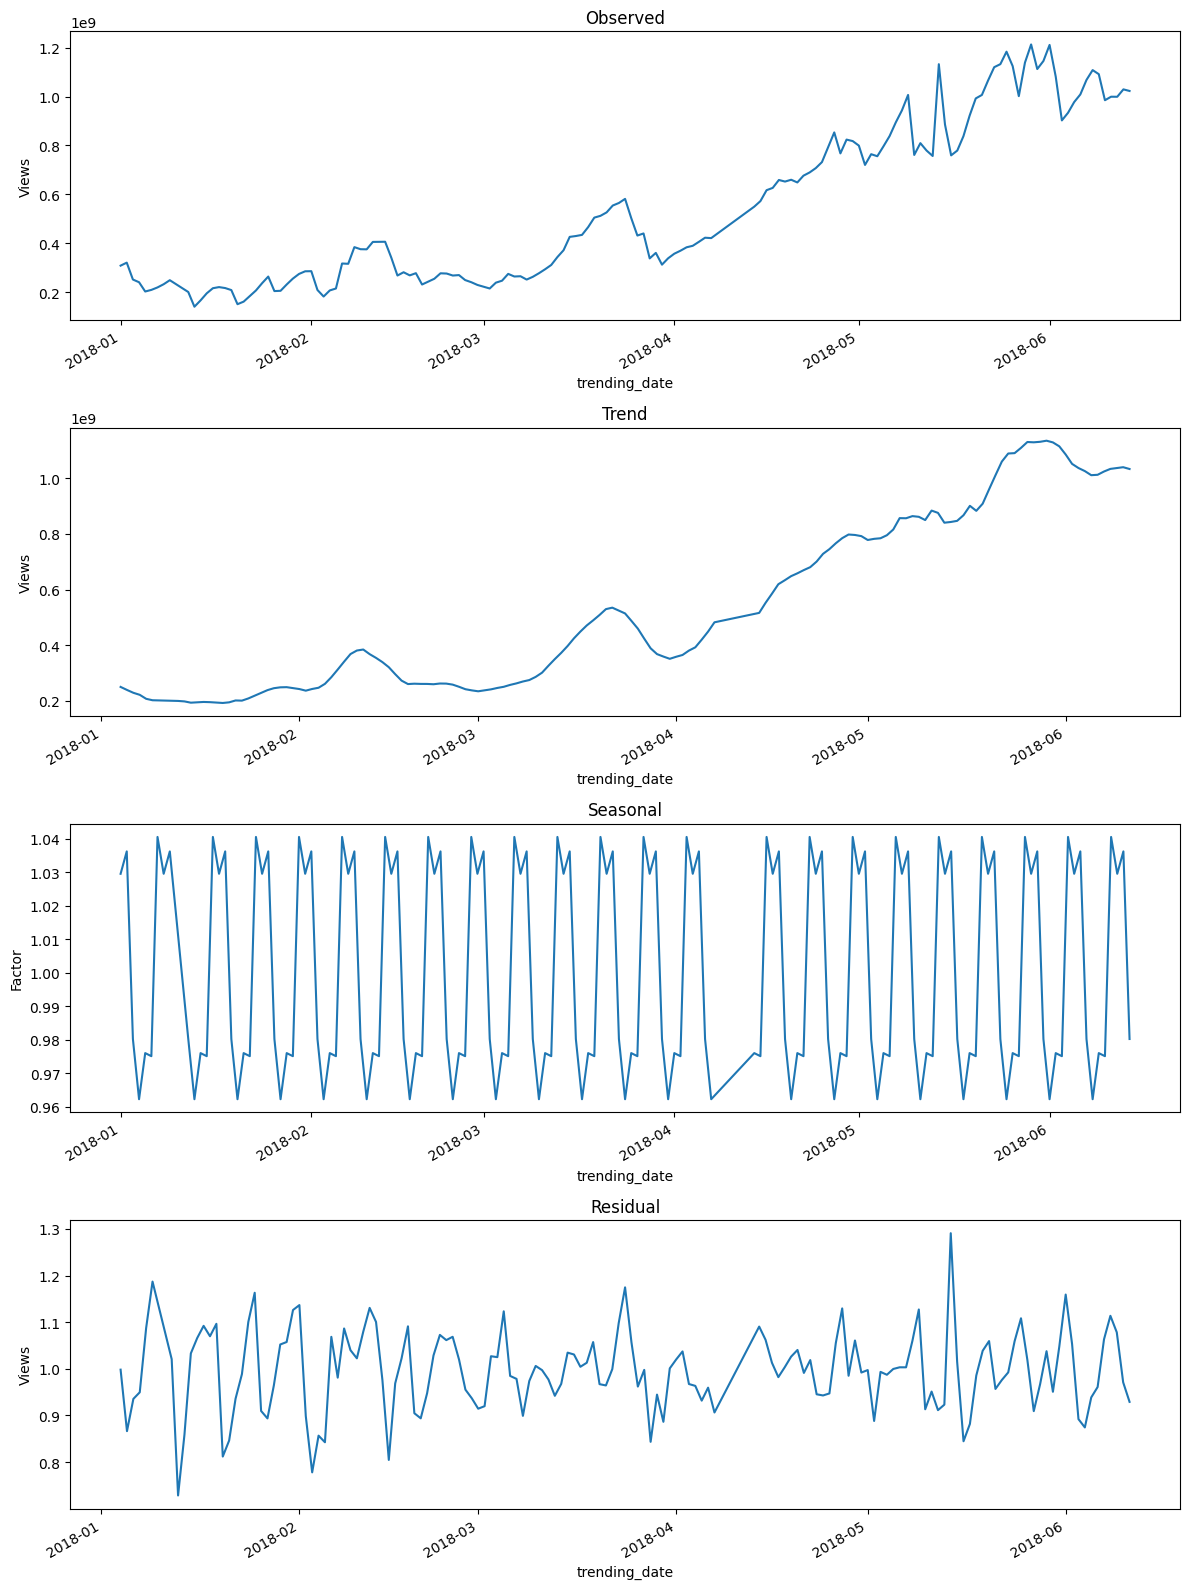

In [12]:
# Deseasonalize the time series
result = seasonal_decompose(daily_views['views'], model='multiplicative', period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
result.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('Views')
result.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Views')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
ax3.set_ylabel('Factor')
result.resid.plot(ax=ax4)
ax4.set_title('Residual')
ax4.set_ylabel('Views')
plt.tight_layout()
plt.show()

### Seasonal Decomposition Analysis

The seasonal decomposition provides further insights into the components of our time series:

1. Trend: The long-term upward trend is clearly visible, confirming the overall growth in daily views throughout 2018.

2. Seasonal: The weekly pattern is evident, with peaks likely corresponding to weekends and troughs to weekdays.

3. Residual: The residual component shows the remaining variation after accounting for trend and seasonality. Large spikes in the residual could indicate viral videos or major events.

This decomposition supports our hypothesis that the day of the week influences video views, as seen in the clear seasonal pattern.

## Hypothesis Testing: First Trending Day of Week Effect on Views

ANOVA test results for trending day effect on views:
F-statistic: 0.72
p-value: 0.6340


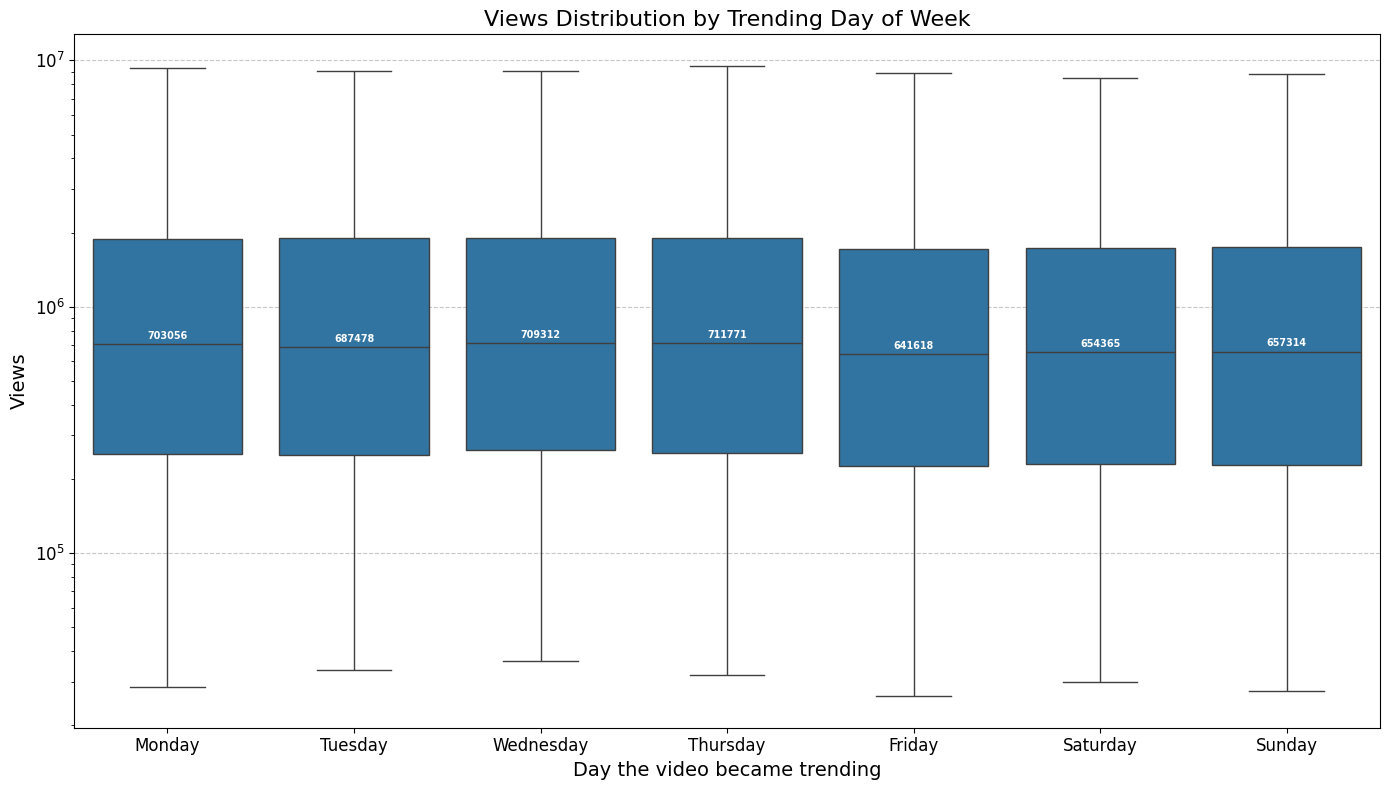

In [13]:
# Prepare data for hypothesis testing
df['trending_day'] = df['trending_date'].dt.day_name()
day_groups = [group['views'].values for name, group in df.groupby('trending_day')]

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*day_groups)

print(f"ANOVA test results for trending day effect on views:")
print(f"F-statistic: {f_statistic:.2f}")
print(f"p-value: {p_value:.4f}")

# Visualize views by trending day of week with improved visibility
plt.figure(figsize=(14, 8))
sns.boxplot(x='trending_day', y='views', data=df, 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            whis=[5, 95],  # Show whiskers at 5th and 95th percentiles
            showfliers=False)  # Hide outlier points to focus on the boxes and whiskers

plt.title('Views Distribution by Trending Day of Week', fontsize=16)
plt.xlabel('Day the video became trending', fontsize=14)
plt.ylabel('Views', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add median values on top of each box
medians = df.groupby('trending_day')['views'].median()
vertical_offset = df['views'].median() * 0.05  # offset for median labels

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, day in enumerate(days):
    plt.text(i, medians[day] + vertical_offset, f'{medians[day]:.0f}', 
             horizontalalignment='center', size='x-small', color='w', weight='semibold')

plt.yscale('log')  # Use log scale for y-axis to better show distribution
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Hypothesis Testing Results

We fail to reject the null hypothesis. The high p-value (0.6340 > 0.05) 
suggests that there is no statistically significant difference in the mean number of views for videos trending on different days of the week.

## Unlike our initial assumption, the day on which a video is trending does not significantly affect its view count. This suggests that once a video is trending, its performance is relatively consistent regardless of the day of the week.


The boxplot visualization further supports this conclusion,
There's almost too much similarity in the distribution of views across all days of the week.
That indicates the possibility that something is wrong with the plot itself. Needs to be rechecked.


## Additional Analysis

Correlation between first-day views and trending duration: 0.21


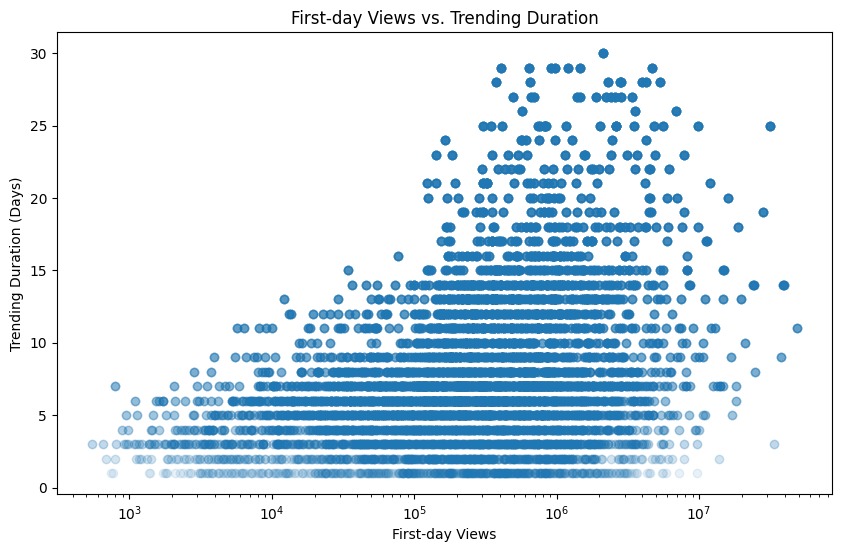

In [14]:
# Calculate correlation between first-day views and trending duration
first_day_views = df.groupby('video_id')['views'].first()
df['first_day_views'] = df['video_id'].map(first_day_views)
correlation = df[['first_day_views', 'trending_duration']].corr().iloc[0, 1]
print(f"Correlation between first-day views and trending duration: {correlation:.2f}")

# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['first_day_views'], df['trending_duration'], alpha=0.1)
plt.title('First-day Views vs. Trending Duration')
plt.xlabel('First-day Views')
plt.ylabel('Trending Duration (Days)')
plt.xscale('log')
plt.show()

## Conclusion and Next Steps

Our analysis has revealed several key insights:

1. There is no significant difference in video views based on the first day of trending.

2. The overall trend of daily views for trending videos is increasing over time.

3. There is a clear weekly seasonality in viewing patterns.

4. The time series of daily views exhibits multiplicative behavior, with increasing volatility over time.

5. There is a moderate positive correlation 0.21 between first-trending-day views and trending duration.


For our next steps, we plan to:

1. Develop a predictive model for the number of days a video will remain on the trending tab, incorporating features like day of publication, initial view count, and category.
2. Investigate the impact of external factors (e.g., holidays, major events) on trending video performance.
